In [96]:
import pandas as pd
import errno    
import os
import numpy as np
import math

'''
Author: Enrico Ceccolini
    Create a dataframe to be used as the base of a power prediction model
'''

datadir = "/datasets/eurora_data/db1/"

infile_jobs_to_nodes = datadir + "job_nodes.csv"

suffix = "_5sec_"
### select an interval from
## 1 settings wholeData
#interval_comment_whole = "WholeData"

### select an interval from
## 2 settings Andrea
interval_comment = "Andrea"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')
#infile_jobs = datadir + "april_long_jobs.csv"

## 3 settings Alina
interval_comment = "Alina"
start_time = pd.to_datetime('2014-03-31')
#start_time = pd.to_datetime('2014-05-31')
end_time = pd.to_datetime('2014-11-01')
train_start_time = pd.to_datetime('2014-03-31')
train_end_time = pd.to_datetime('2014-10-01')
test_end_time = pd.to_datetime('2014-11-01')

infile_jobs = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_long_jobs_real_pow"
#infile_long_jobs = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_long_jobs_real_pow_64_359350"

nodes=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']

In [97]:
jobs_to_nodes_whole_data = pd.read_csv(infile_jobs_to_nodes, index_col=0)
print("jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

jobs = pd.read_csv(infile_jobs + ".csv", index_col=0)
print("There are {} long jobs in the {}'s interval".format(jobs.shape[0], interval_comment))

# clean user names
jobs['user'] = jobs.apply(lambda row: row['user'].split('@')[0], axis=1)

jobs_to_nodes_whole_data contains 469095 records


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 336787 long jobs in the Alina's interval


In [98]:
jobs.head(1)

,job_id_string,job_name,queue,start_time,run_start_time,end_time,user,node_req,cpu_req,mem_req,...,mic_req,real_pow,ran_alone,real_pow_quality,n_2_1,n_2_2,n_3_1,job_tot_timepoints,job_timepoints,good_nodes
job_id,,,,,,,,,,,,,,,,,,,,,
1,498458.node129,rth2e6t0,parallel,2014-03-31 00:30:02,2014-03-31 00:30:02,2014-03-31 01:22:40,alupi000,1,16,14,...,NaN,0.0,True,1.0,0,1,0,631,631,0


In [102]:
jobs_q1 = jobs[jobs['real_pow_quality'] > 0]
jobs_q1 = jobs_q1[jobs_q1['real_pow'] > 0]
print(jobs_q1.shape[0])

165126


In [103]:

#target = jobs['real_pow']

# drop unused (or not usable) info
#data = jobs_q1.drop(['job_id_string'], axis=1)
data = jobs_q1.drop(['start_time'], axis=1)
data = data.drop(['job_tot_timepoints'], axis=1) #<--- Andrea
data = data.drop(['job_timepoints'], axis=1) #<--- Andrea
data = data.drop(['good_nodes'], axis=1) #<--- Andrea
data = data.drop(['exit_status'], axis=1)
data = data.drop(['pbs_exit_code'], axis=1)
data = data.drop(['deleted'], axis=1)
data = data.drop(['dependency'], axis=1)
data = data.drop(['real_pow_quality'], axis=1)
data = data.drop(['time_req'], axis=1)
#data = data.drop(['real_pow'], axis=1)
#data = data.drop(['job_name'], axis=1)

data = data.drop(['gpu_req'], axis=1)
data = data.drop(['mic_req'], axis=1)

data.keys()

Index(['job_id_string', 'job_name', 'queue', 'run_start_time', 'end_time',
       'user', 'node_req', 'cpu_req', 'mem_req', 'real_pow', 'ran_alone',
       'n_2_1', 'n_2_2', 'n_3_1'],
      dtype='object')

In [104]:
jobs_train = data[pd.to_datetime(data['end_time']) <= train_end_time]
jobs_train = jobs_train[pd.to_datetime(jobs_train['run_start_time']) > train_start_time]
print("train set contains {} records".format(jobs_train.shape[0]))

train_target = jobs_train['real_pow']
#jobs_train = jobs_train.drop(['run_start_time'], axis=1)
#jobs_train = jobs_train.drop(['end_time'], axis=1)
#jobs_train = jobs_train.drop(['real_pow'], axis=1)

jobs_test = data[pd.to_datetime(data['end_time']) <= test_end_time]
jobs_test = jobs_test[pd.to_datetime(jobs_test['run_start_time']) > train_end_time]
print("test set contains {} records".format(jobs_test.shape[0]))
test_target = jobs_test['real_pow']
#jobs_test = jobs_test.drop(['run_start_time'], axis=1)
#jobs_test = jobs_test.drop(['end_time'], axis=1)
#jobs_test = jobs_test.drop(['real_pow'], axis=1)

train set contains 146901 records
test set contains 18224 records


In [105]:
###### NB eseguire solo se non si vogliono job sotto 5 sec

#jobs_test = jobs_test[pd.to_datetime(jobs_test['end_time']) - pd.to_datetime(jobs_test['run_start_time']) > np.timedelta64(5, 's')]
#jobs_test.shape[0]
#test_target = jobs_test['real_pow']

In [106]:
###### NB eseguire solo for Andrea's split
#from sklearn.model_selection import train_test_split
#
#jobs_data_features = data.loc[ : , ['job_name', 'queue', 'user', 'node_req', 'cpu_req', 'mem_req', 'ran_alone', 'n_2_1', 'n_2_2', 'n_3_1'] ]
## create test and training set
#jobs_train, jobs_test, train_target, test_target = train_test_split(jobs_data_features, data['real_pow'], test_size = 0.2, random_state = 42)
#
#print(jobs_train.shape[0])
#print(jobs_test.shape[0])

In [107]:
data.head(5)

,job_id_string,job_name,queue,run_start_time,end_time,user,node_req,cpu_req,mem_req,real_pow,ran_alone,n_2_1,n_2_2,n_3_1
job_id,,,,,,,,,,,,,,
2,498459.node129,CPMD,parallel,2014-03-31 00:36:51,2014-03-31 00:40:13,framondo,1,16,14,213.907235,True,1,0,0
3,498460.node129,7ribb-relax,parallel,2014-03-31 00:54:38,2014-03-31 04:55:17,vcalzia0,6,96,84,1232.722332,True,5,1,0
4,498461.node129,rth2e6t0DC,parallel,2014-03-31 01:00:02,2014-03-31 05:01:18,alupi000,1,16,14,204.154343,True,1,0,0
8,498465.node129,INIT,R472836,2014-03-31 04:00:17,2014-03-31 07:50:11,a07smr01,1,1,2,4.619396,False,0,0,1
9,498466.node129,LM_PRE,R472836,2014-03-31 04:00:18,2014-03-31 04:23:30,a07smr01,11,176,154,3437.597435,True,0,0,11


In [108]:
print(data.shape[0])

165126


In [109]:
## time req
#data['time_req'].unique()
#data[data['time_req'].isnull()].shape[0]
#data.loc[data['time_req'] == '--', 'time_req'] = np.nan
#y = data.time_req.str.split(':')   
#i, j = y.str[0], y.str[1]  
#
#data['time_req'] = i.astype(int) + (j.astype(float) / 60) 
#data.head(5)

In [110]:
#debug
jobs_train['job_name'].unique().shape[0]


6284

In [111]:
jobs_train.columns

Index(['job_id_string', 'job_name', 'queue', 'run_start_time', 'end_time',
       'user', 'node_req', 'cpu_req', 'mem_req', 'real_pow', 'ran_alone',
       'n_2_1', 'n_2_2', 'n_3_1'],
      dtype='object')

In [120]:
# select feautures columns

jobs_train_features = jobs_train.loc[ : , ['job_name', 'queue', 'user', 'node_req', 'cpu_req', 'mem_req', 'ran_alone', 'n_2_1', 'n_2_2', 'n_3_1'] ]
jobs_test_features = jobs_test.loc[ : , ['job_name', 'queue', 'user', 'node_req', 'cpu_req', 'mem_req', 'ran_alone', 'n_2_1', 'n_2_2', 'n_3_1'] ]

#jobs_train_features = jobs_train.loc[ : , ['queue', 'user', 'node_req', 'cpu_req', 'mem_req', 'ran_alone', 'n_2_1', 'n_2_2', 'n_3_1'] ]
#jobs_test_features = jobs_test.loc[ : , ['queue', 'user', 'node_req', 'cpu_req', 'mem_req', 'ran_alone', 'n_2_1', 'n_2_2', 'n_3_1'] ]

In [121]:
jobs_train_features.columns

Index(['job_name', 'queue', 'user', 'node_req', 'cpu_req', 'mem_req',
       'ran_alone', 'n_2_1', 'n_2_2', 'n_3_1'],
      dtype='object')

In [122]:
from sklearn.feature_extraction import FeatureHasher
import copy
from sklearn.ensemble import RandomForestRegressor


import time
start_time = time.time()

X_train_hash = copy.copy(jobs_train_features)
X_test_hash = copy.copy(jobs_test_features)
for i in range(X_train_hash.shape[1]):
    X_train_hash.iloc[:,i]=X_train_hash.iloc[:,i].astype('str')
for i in range(X_test_hash.shape[1]):
    X_test_hash.iloc[:,i]=X_test_hash.iloc[:,i].astype('str')
h = FeatureHasher(n_features=1000, input_type="string")
X_train_hash = h.transform(X_train_hash.values)
X_test_hash = h.transform(X_test_hash.values)

print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()

regr = RandomForestRegressor()
regr.fit(X_train_hash,train_target)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.4815213680267334 seconds ---


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--- 36.96151924133301 seconds ---


In [126]:
#regr = RandomForestRegressor()
#regr.fit(X_train_hash,train_target)


#l.fit(X_train_hash,y_train)
#y_pred = l.predict_proba(X_test_hash)
#print(log_loss(y_test,y_pred))#0.4

In [127]:
from sklearn.model_selection import cross_val_score
print("[RandomForestRegressor] Train data Accuracy: %0.2f " % regr.score(X_train_hash, train_target))

print("[RandomForestRegressor] Test data Accuracy: %0.2f " % regr.score(X_test_hash, test_target))

[RandomForestRegressor] Train data Accuracy: 0.94 
[RandomForestRegressor] Test data Accuracy: 0.75 


In [128]:
test_predictions = regr.predict(X_test_hash)
test_predictions.shape[0]

18224

In [129]:
jobs_test_full = data[pd.to_datetime(data['end_time']) <= test_end_time]
jobs_test_full = jobs_test_full[pd.to_datetime(jobs_test_full['run_start_time']) > train_end_time]

# execute this for jobs shorter tha 5 sec
#jobs_test_full = jobs_test_full[pd.to_datetime(jobs_test_full['end_time']) - pd.to_datetime(jobs_test_full['run_start_time']) > np.timedelta64(5, 's')]

jobs_test_full['predict_rf'] = test_predictions

#jobs_test.shape[0]
#test_target = jobs_test['real_pow']

mean_real_pow = jobs_test_full['real_pow'].mean()
print("the mean is {}".format(mean_real_pow))

jobs_test_full['numerator'] = (jobs_test_full['real_pow'] - jobs_test_full['predict_rf'])**2
jobs_test_full['denumerator'] = (jobs_test_full['real_pow'] - mean_real_pow)**2
N = jobs_test_full['numerator'].shape[0]

r_2 = 1 - (jobs_test_full['numerator'].sum() / jobs_test_full['denumerator'].sum())
print("r_2 is {}".format(r_2))

rmse = math.sqrt(jobs_test_full['numerator'].sum() / N)
print("RMSE is {}".format(rmse))
print("NRMSE is {}".format(rmse/mean_real_pow))

the mean is 75.89084796065079
r_2 is 0.747721589153159
RMSE is 90.20490989297143
NRMSE is 1.1886138093982352


In [130]:
import datetime

infile_nodes = datadir + "nodes.csv"

nodes = pd.read_csv(infile_nodes, index_col=0)
#print(nodes.shape[0])

### merge the info from the two tables
merged_jobs_to_nodes = pd.merge(jobs_test_full, jobs_to_nodes_whole_data, how='left', on='job_id_string')
print("merged_jobs_to_nodes contains {} records".format(merged_jobs_to_nodes.shape[0]))

period = (test_end_time - train_end_time)
period = period.total_seconds() / 5 # total seconds / 5
interval_serie = pd.date_range(train_end_time, periods=period, freq='5s')
frame = { 'timestamp': interval_serie }
all_time_interval_power_consumption = pd.DataFrame(frame)

merged_jobs_to_nodes contains 18843 records


In [131]:
def calculate_power_consumption(node_str, node_core_idle, interval_size, node_start_time):
    
    # num_minutes = 535680 
    # node_start_time = pd.to_datetime('2014-03-31 00:00:00')
    total_approx_power_consumption = pd.Series(0, index=np.arange(interval_size))
    total_active_cores = pd.Series(0, index=np.arange(interval_size))
    total_real_power_consumption = pd.Series(0, index=np.arange(interval_size))
    
    jobs_to_node = merged_jobs_to_nodes[merged_jobs_to_nodes['node_id'] == int(node_str)]
    #infile_node = datadir + "CPUs/" + interval_comment + "/node" + node_str + suffix + interval_comment + "_active_cores_and_jobs"
    #node_data = pd.read_csv(infile_node + ".csv")
    
    power_consumption_real = pd.Series(0, index=np.arange(interval_size))
    power_consumption_pred = pd.Series(0, index=np.arange(interval_size))
    active_cores = pd.Series(0, index=np.arange(interval_size))
    
    i = 0
    num_jobs = jobs_to_node.shape[0]
    print("{}".format(num_jobs))
    for job_index, job_row in jobs_to_node.iterrows():
        
        #print("{}/{}".format(i, num_jobs))
        i = i + 1
        job_start_time = pd.to_datetime(job_row['run_start_time'])
        job_end_time = pd.to_datetime(job_row['end_time'])
        job_cores = job_row['ncpus']
        job_cores_total = job_row['cpu_req']
        #job_gpus = row['ngpus']
        #job_mics = row['nmics']
        job_power_consumption_pred = job_row['predict_rf'] * (job_cores / job_cores_total) # real_pow contains the total, here we need only the node portion
        job_power_consumption_real = job_row['real_pow'] * (job_cores / job_cores_total) # real_pow contains the total, here we need only the node portion
        
        
        # print(job_power_consumption_pred)

        before_minutes = int((job_start_time - pd.to_datetime(node_start_time) - np.timedelta64(5, 's')) / np.timedelta64(5, 's'))
        running_minutes = int((job_end_time - job_start_time) / np.timedelta64(5, 's'))
        after_minutes = interval_size - running_minutes - before_minutes

        #pred
        before_serie = pd.Series(0, index=np.arange(before_minutes))
        running_serie = pd.Series(job_power_consumption_pred, index=np.arange(running_minutes))
        after_serie = pd.Series(0, index=np.arange(after_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        power_consumption_pred = power_consumption_pred.add(concat_series, fill_value=0)
        
        # real
        running_serie = pd.Series(job_power_consumption_real, index=np.arange(running_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        power_consumption_real = power_consumption_real.add(concat_series, fill_value=0)

        running_serie = pd.Series(job_cores, index=np.arange(running_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        active_cores = active_cores.add(concat_series, fill_value=0)

        
    #for x in range(0, 17):
    #    # active_cores[active_cores == x] += (node_core_idle * 16) * (16 - x) / 16
    #    active_cores[active_cores == x] += node_core_idle * (16 - x)
    #
    #power_consumption_pred = power_consumption_pred.add(active_cores, fill_value=0)
    #power_consumption_real = power_consumption_real.add(active_cores, fill_value=0)
        
    #indices = node_data['active_cores'] == 0
    #node_data.at[indices, 'pow_tot'] = node_core_idle * 16
    #total_real_power_consumption = node_data['pow_tot']
    
    return power_consumption_real, power_consumption_pred

In [132]:
infile_validate_approx = datadir + "CPUs/" + interval_comment + "/validate_pred_rf_" + interval_comment + ".csv"

# per ogni nodo sommo quanto è stato il consumo ad ogni intervallo in un vettore parallelo
# questo sia per il valore approssimato guardando i job
# sia per il valore reale
j = 0
for node_index, node_row in nodes.iterrows():
    node_id = node_row['node_id']
    if( int(node_id) < 10):
        node_id = "0" + str(node_id)
    else:
        node_id = str(node_id)
    print(node_id)
    node_core_idle = node_row['core_idle']
    
    if (node_id != "43"):
        total_real_power_consumption, total_pred_power_consumption = calculate_power_consumption(node_id, node_core_idle, period, train_end_time)
        all_time_interval_power_consumption[node_id + "_real"] = total_real_power_consumption
        all_time_interval_power_consumption[node_id + "_pred"] = total_pred_power_consumption
    
    if(j%10 == 0):
        all_time_interval_power_consumption.to_csv(infile_validate_approx)
all_time_interval_power_consumption.to_csv(infile_validate_approx)

01
46
02
0
03
51
04
38
05
0
06
40
07
76
08
47
09
0
10
40
11
37
12
0
13
35
14
0
15
0
16
0
17
761
18
26
19
40
20
34
21
21
22
0
23
35
24
41
25
43
26
41
27
42
28
30
29
32
30
47
31
56
32
0
33
1829
34
2365
35
1105
36
0
37
247
38
1670
39
7
40
193
41
0
42
145
43
44
1728
45
239
46
228
47
114
48
859
49
84
50
113
51
110
52
0
53
0
54
622
55
506
56
105
57
73
58
77
59
122
60
1225
61
549
62
791
63
1777
64
301


In [133]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_line(data_dates, data_real, data_approx, days_interval):
    plt.rcParams['figure.figsize'] = (20,5)

    X_AXIS_NAME = 'Time (min)'
    Y_AXIS_NAME = 'Power (W)'
    # TITLE = 'Nodes power consumption - Andrea\'s data'

    fig, ax = plt.subplots()
    ax.xaxis.get_majorticklabels()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=days_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='both', which='major', labelsize=15)

    dates = []
    colors = ("orange", "blue")
    #colors = ("orange", "green")

    for ts in data_dates['timestamp']:
        local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
        dates.append(local_d)


    plt.plot(dates, data_real, c=colors[1], alpha=0.5)
    plt.plot(dates, data_real, c=colors[1])
    
    plt.plot(dates, data_approx, c=colors[0], alpha=1)

    #plt.plot(dates, data_real, c=colors[1], alpha=0.6, dashes=[2, 2])
    
    #plt.scatter(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'])

    #fig.autofmt_xdate()
    plt.xlabel(X_AXIS_NAME, fontsize=20)
    plt.ylabel(Y_AXIS_NAME, fontsize=20)
    # plt.title(TITLE)

    # function to show the plot
    plt.show()
    #fig.savefig('graph.png', dpi=fig.dpi)

In [134]:
infile_approximated = datadir + "CPUs/" + interval_comment + "/validate_pred_rf_" + interval_comment + ".csv"
predicted_power_consumptions = pd.read_csv(infile_approximated)

#approximated_power_consumption = approximated_power_consumption[pd.to_datetime(approximated_power_consumption['timestamp']) >= pd.to_datetime('2014-03-31 11:21:00')]
#approximated_power_consumption = approximated_power_consumption[pd.to_datetime(approximated_power_consumption['timestamp']) <= pd.to_datetime('2014-04-30 20:32:00')]
#predicted_power_consumptions = predicted_power_consumptions[pd.to_datetime(predicted_power_consumptions['timestamp']) >= pd.to_datetime('2014-10-01 11:21:00')]
predicted_power_consumptions = predicted_power_consumptions[pd.to_datetime(predicted_power_consumptions['timestamp']) <= pd.to_datetime('2014-10-07 18:30:00')]

#approx = approximated_power_consumption.select(lambda col: col.endswith("approx"), axis=1)
real = predicted_power_consumptions.select(lambda col: col.endswith("real"), axis=1)
predicted = predicted_power_consumptions.select(lambda col: col.endswith("pred"), axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


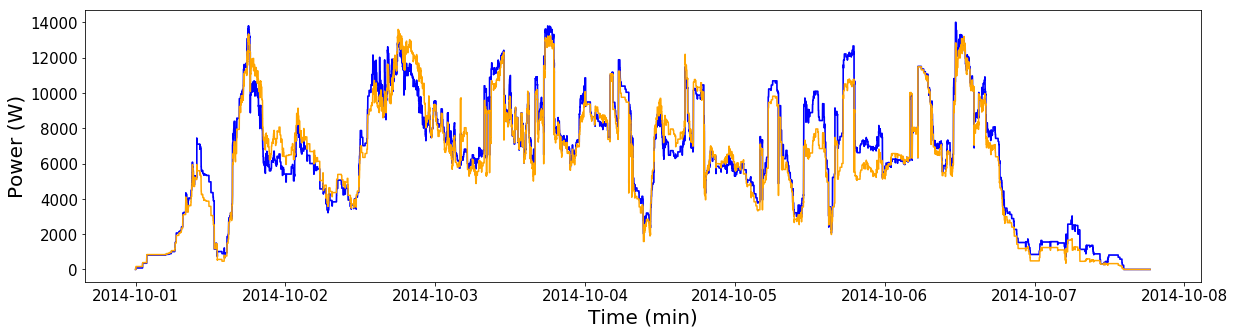

In [135]:
#approx['Total'] = approx.iloc[:, -64:-1].sum(axis=1)
real['Total'] = real.iloc[:, -64:-1].sum(axis=1)
predicted['Total'] = predicted.iloc[:, -64:-1].sum(axis=1)
#differences = approx['Total'] - predicted['Total']
#df = pd.DataFrame(differences)
#df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['Total']

#plot_hist(n_bins=150, data=differences)
#plot_hist(n_bins=150, data=differences_norm)

#plot_line(data_dates=approximated_power_consumption, data_real=real['Total'], data_approx=predicted['Total'], days_interval=5)
plot_line(data_dates=predicted_power_consumptions, data_real=real['Total'], data_approx=predicted['Total'], days_interval=1)

#print("approximation accuracy: {}".format(r2_score(real['Total'], approx['Total'])))

In [61]:
# print(X_train_hash)

In [46]:
#qs = []
#for q in data['queue']:
#    if not q in qs:
#        qs.append(q)
#us = []
#for u in data['user']:
#    if not u in us:
#        us.append(u)
#jns = []
#for jn in data['job_name']:
#    if not jn in jns:
#        jns.append(jn)

# convert categorical data
#print('job_name')
#dms = pd.get_dummies(data['job_name'])
#data = pd.concat([data, dms], axis=1)    
#data = data.drop(['job_name'], axis=1)

print('queue')
dms = pd.get_dummies(data['queue'])
data = pd.concat([data, dms], axis=1)    
data = data.drop(['queue'], axis=1)

print('user')
dms = pd.get_dummies(data['user'])
data = pd.concat([data, dms], axis=1)    
data = data.drop(['user'], axis=1)


# delete rows  with missing values
data = data.dropna()
#target = target.dropna()

target = data['real_pow']
data = data.drop(['real_pow'], axis=1)

features_list = list(data.columns)
# print(features_list)

# convert panda dataframe into numpy arrays
data_np = np.array(data)
target_np = np.array(target)

# scale (obtain data with zero mean and unit variance)
#data_scaled = preprocessing.scale(data_np)
#target_scaled = preprocessing.scale(target_np)
data_scaled = data_np
target_scaled = target_np

data.iloc[:,5:].head(5)

queue
user


,n_2_2,n_3_1,R1010870,R1010998,R1011000,R1013900,R1013901,R1013902,R1013903,R1013904,...,tbusatta,tgiorgin,tjones00,tlucchin,vcalzia0,vdalcol0,vmarino0,vmiglior,vruggie1,wxie0000
job_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print(data_scaled.shape[0])
print(target_scaled.shape[0])

274889
274889


trying to use the train_test_split

In [6]:
# select feautures columns

data_features = data.loc[ : , ['job_name', 'queue', 'user', 'node_req', 'cpu_req', 'mem_req', 'ran_alone', 'n_2_1', 'n_2_2', 'n_3_1'] ]
data_target = data['real_pow']

In [7]:
from sklearn.model_selection import train_test_split

# create test and training set
train_data, test_data, train_target, test_target = train_test_split(data_features, data_target, test_size = 0.2, random_state = 42)

In [8]:
print(train_data.shape[0])
print(test_data.shape[0])

248937
62235


In [9]:
from sklearn.feature_extraction import FeatureHasher
import copy
from sklearn.ensemble import RandomForestRegressor


X_train_hash = copy.copy(train_data)
X_test_hash = copy.copy(test_data)
for i in range(X_train_hash.shape[1]):
    X_train_hash.iloc[:,i]=X_train_hash.iloc[:,i].astype('str')
for i in range(X_test_hash.shape[1]):
    X_test_hash.iloc[:,i]=X_test_hash.iloc[:,i].astype('str')
h = FeatureHasher(n_features=1000, input_type="string")
X_train_hash = h.transform(X_train_hash.values)
X_test_hash = h.transform(X_test_hash.values)

In [10]:
regr = RandomForestRegressor()
regr.fit(X_train_hash,train_target)


#l.fit(X_train_hash,y_train)
#y_pred = l.predict_proba(X_test_hash)
#print(log_loss(y_test,y_pred))#0.4

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
from sklearn.model_selection import cross_val_score
print("[RandomForestRegressor] Train data Accuracy: %0.2f " % regr.score(X_train_hash, train_target))

print("[RandomForestRegressor] Test data Accuracy: %0.2f " % regr.score(X_test_hash, test_target))

[RandomForestRegressor] Train data Accuracy: 0.82 
[RandomForestRegressor] Test data Accuracy: 0.72 


In [32]:
from sklearn.model_selection import train_test_split

# create test and training set
train_data, test_data, train_target, test_target = train_test_split(data_scaled, target_scaled, test_size = 0.2, random_state = 42)

In [33]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr.fit(train_data,train_target)



/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
from sklearn.model_selection import cross_val_score
print("[RandomForestRegressor] Train data Accuracy: %0.2f " % regr.score(train_data, train_target))


print("[RandomForestRegressor] Test data Accuracy: %0.2f " % regr.score(test_data, test_target))

[RandomForestRegressor] Train data Accuracy: 0.74 
[RandomForestRegressor] Test data Accuracy: 0.70 
